# Imports

In [132]:
import pickle
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
import nltk
import contractions
import spacy
from scipy.sparse import hstack
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from xgboost import XGBClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vasco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vasco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [133]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


In [134]:
# Reading csv file and converting it to a DataFrame
def read_csv_to_dataframe(filename):
    df = pd.read_csv("./data/" + filename)
    return df

In [135]:
# Filtering dataframe for genres in our list and rows with all collumnds filled
def filter_dataframe(df, genres):
    df = df[df['Genre'].isin(genres)]
    df = df.dropna()
    return df

In [136]:
# Add headers to train.txt dataframe

def addHeadersToTrain(df):
    df.columns = ['Title','Origin/Ethnicity' ,'Genre', 'Director', 'Plot']
    return df

In [137]:
# Balance dataset (Remove from drama)

def balance_dataset(df):
    drama_movies = df[df['Genre'] == 'drama']
    random_drama_sample = drama_movies.sample(n=500, random_state=42)  # random_state ensures reproducibility
    df = df.drop(random_drama_sample.index)
    return df

In [138]:
# Try to increase Sci-fi

#TODO - Ir ao filmesDataset, pegar nos filmes sci-fi
#TODO - Comparar com o train.txt para não haver repetidos
#TODO - Comparar com o test.txt para não haver repetidos
#TODO - Adicionar ao train.txt

def increase_scifi(df):
    filmesDataset = read_csv_to_dataframe('filmesDataset.csv')
    top_secret = read_file_to_dataframe('top_secret_69.txt')
    top_secret.columns = ['Title','Origin/Ethnicity' , 'Director', 'Plot']
    
    sci_fi_movies = filmesDataset[filmesDataset['Genre'] == 'sci-fi']

    unique_sci_fi_movies = sci_fi_movies[~sci_fi_movies['Title'].isin(df['Title'])]

    unique_sci_fi_movies = unique_sci_fi_movies[~unique_sci_fi_movies['Title'].isin(top_secret['Title'])]

    df = pd.concat([df, unique_sci_fi_movies])

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)    
    
    return df

# Variaveis onde está os ficheiros de treino e o modelo

In [139]:
#file onde já está o modelo treinado"
model=None

#limpesa de ficheiro de treino
# data="filmesDataset"
data= "train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [140]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
allowed_genres = ["drama", "comedy", "horror", "action", "romance", "western", "animation", "crime", "sci-fi"]

# df = read_csv_to_dataframe(data+".csv")
# df = df.drop(columns=['Unnamed: 8'])
df = read_file_to_dataframe(data+".txt")
df = addHeadersToTrain(df)
df = filter_dataframe(df, allowed_genres)
# df = balance_dataset(df)
df = increase_scifi(df)
print(df)


Data to DataFrame

                                             Title Origin/Ethnicity    Genre  \
0                                The Black Balloon       Australian    drama   
1                                          BoyTown       Australian   comedy   
2                                        Vajrakaya          Kannada   action   
3                                       Characterz         American   comedy   
4                              Oru Naal Oru Kanavu            Tamil  romance   
...                                            ...              ...      ...   
8047                                      Lovesong         American    drama   
8048                             The Devil's Agent          British    drama   
8049  The Osiris Child: Science Fiction Volume One       Australian   sci-fi   
8050                                  The Shootist         American  western   
8051                                  Dracula 2000         American   horror   

                  Di

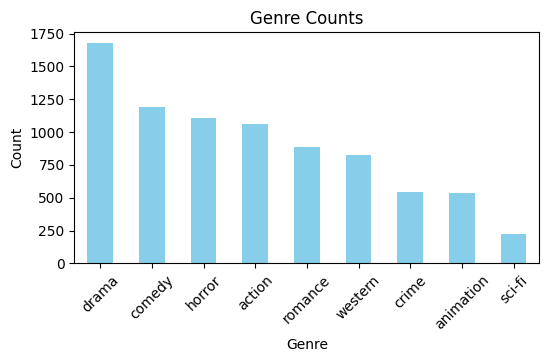

Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        225
Name: count, dtype: int64


In [141]:
# Genre Count for train dataset

genre_counts = df['Genre'].value_counts()

# Plot the histogram
plt.figure(figsize=(6, 3))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(genre_counts)

8052
Average word count: 370.51


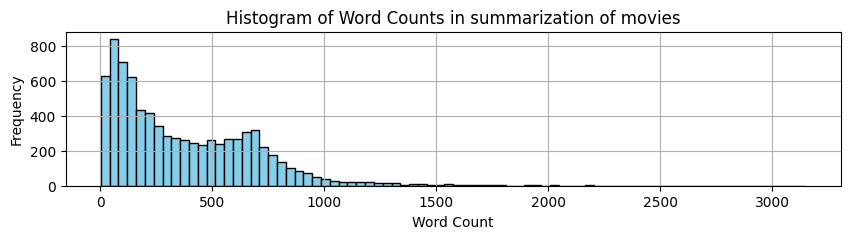

In [142]:
# histogram of word count
print(len(df))


df['word_count'] = df['Plot'].apply(lambda x: len(x.split())) 
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 161345
to: 111785
and: 106223
a: 80258
of: 53600
is: 49148
in: 43896
his: 43895
he: 30914
that: 30807


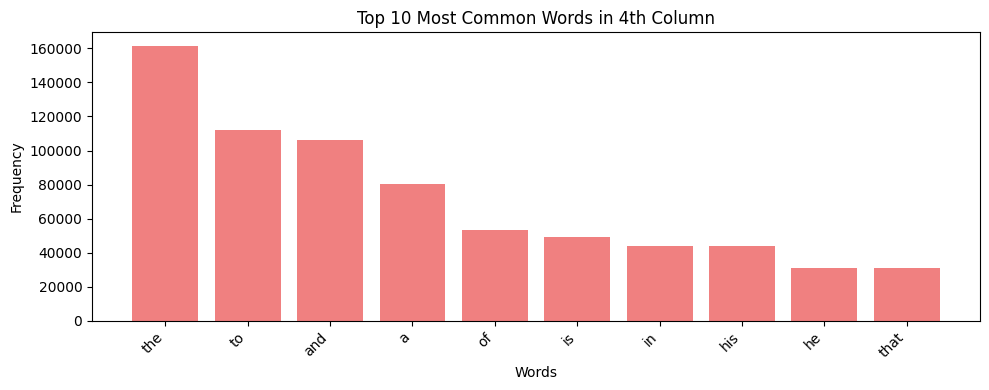

In [143]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df['Plot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

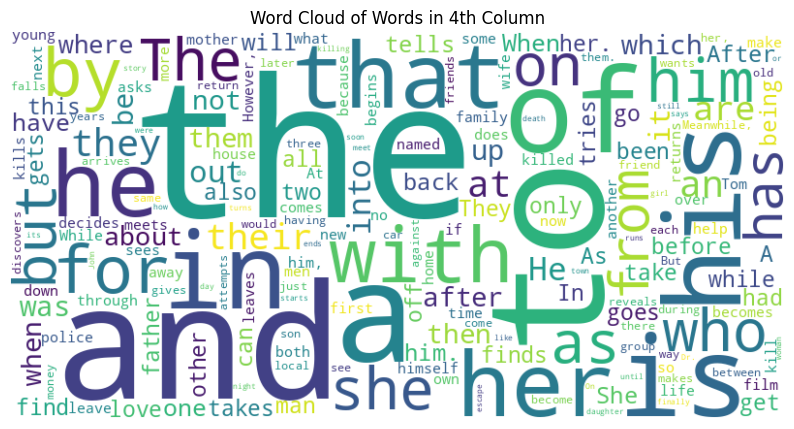

In [144]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [145]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110310

Potential typos detected:
regice
reborn,
mumolo).
loves,
rakesh
lomax's
masked-ball,
anshu
full-blown
cat,
galina,
reformer,
grauer),
delgado
albert
(vikram),
darkness,
rodgers),
peet),
raghava
o'connell),
run-ins,
(nostradamus)
rajaram's
mehra.
असंही
pritchard.
safia
off-center
seriously.
encouragement.
hanover's
alligator-man)
kerrigans'
(javier
belongings.
overdog
thunderstorm,
jeweller’s
imprisoned;
jug,
viktor
corporal,
meanwhile;
moriwaki
farrar),
stick.
neelu
j.w.'s
(asmita
newly-youthful
gambling.
bakar
wheatbelt
mckay's
wellmore,
bunag
freakshow
bakke),
cho,
koccha
rajvansh's
smoking)
sakhina)
embry),
20th
kahdem
shaft.
was,
co
never-smiling
festival.
wonders,
secured,
cell’s
huling,
(ismat)
swiss
geronimo.
(dharmendra).
colby,
feud.[4]
drug-addicted
whites.
nods,
fiction,
followers—now
(as
kush
fishes,
chandrakanth
leutnant
curious,
pets,
taken.
futile.
ipkiss
snake-man,
pretorius.
bear-clad
(siobhan
birthday).
purushottam's
deivanayaki
cef.

## Pre Processamento

In [146]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [147]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [148]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [149]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [150]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [151]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [152]:
def remove_references(text):
    # Substituir ".[\d]" por "."
    text = re.sub(r'\.\[\d+\]', '.', text)
    
    return text

In [153]:
print("\033[34mPre Processing the data\n\033[0m")
line_counter = 0

def preprocess_text(text):
    global line_counter
    print(f"Processing line {line_counter + 1}...")   # Print the line being processed
    line_counter += 1 
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    text = remove_references(text)         # Step 7: Remove references
    
    return text

# Example usage

Pre Processing the data



In [154]:
df['ProcPlot'] = df['Plot'].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Processing line 1...
Processing line 2...
Processing line 3...
Processing line 4...
Processing line 5...
Processing line 6...
Processing line 7...
Processing line 8...
Processing line 9...
Processing line 10...
Processing line 11...
Processing line 12...
Processing line 13...
Processing line 14...
Processing line 15...
Processing line 16...
Processing line 17...
Processing line 18...
Processing line 19...
Processing line 20...
Processing line 21...
Processing line 22...
Processing line 23...
Processing line 24...
Processing line 25...
Processing line 26...
Processing line 27...
Processing line 28...
Processing line 29...
Processing line 30...
Processing line 31...
Processing line 32...
Processing line 33...
Processing line 34...
Processing line 35...
Processing line 36...
Processing line 37...
Processing line 38...
Processing line 39...
Processing line 40...
Processing line 41...
Processing line 42...
Processing line 43...
Processing line 44...
Processing line 45...
Processing line 46.

find: 9122
kill: 8886
take: 8502
go: 7941
get: 7744
leave: 7436
one: 6748
tell: 6656
man: 6608
back: 5720


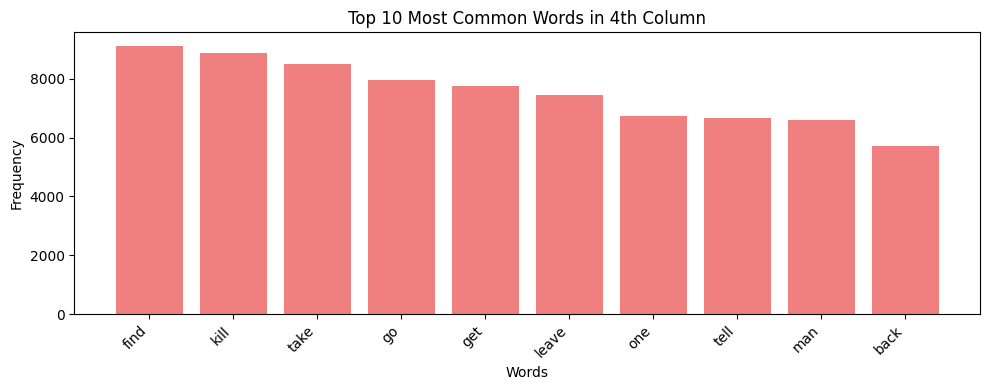

In [155]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df['ProcPlot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

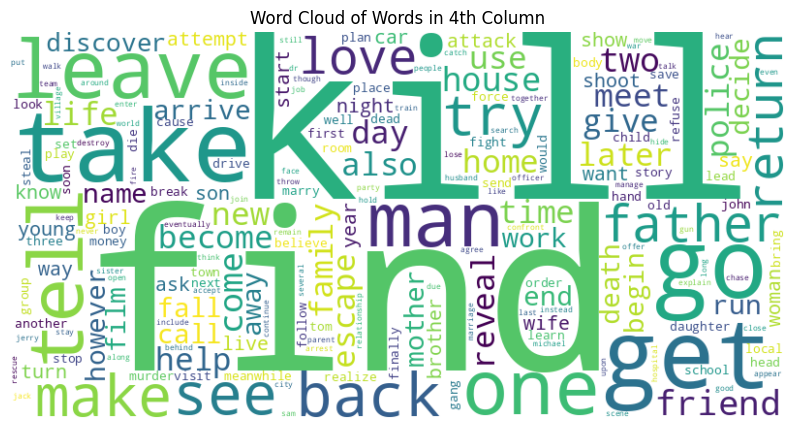

In [156]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'pklToUse'

In [157]:
pklToUse = "dramaGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['ProcPlot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['drama'] = df['Genre'].apply(lambda genres: 1 if 'drama' in genres else 0)

    y = df['drama']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.3727374  0.03828287 0.07554987 0.45681535 0.19665951]
Accuracy: 0.83


In [158]:
pklToUse = "comedyGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['ProcPlot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['comedy'] = df['Genre'].apply(lambda genres: 1 if 'comedy' in genres else 0)

    y = df['comedy']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.00180514 0.01559644 0.05335417 0.27961748 0.0279789 ]
Accuracy: 0.88


In [159]:
pklToUse = "horrorGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['ProcPlot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['horror'] = df['Genre'].apply(lambda genres: 1 if 'horror' in genres else 0)

    y = df['horror']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.07624231 0.03094794 0.01029267 0.00987061 0.01797419]
Accuracy: 0.94


In [160]:
pklToUse = "actionGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['ProcPlot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['action'] = df['Genre'].apply(lambda genres: 1 if 'action' in genres else 0)

    y = df['action']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.08265233 0.5        0.30315632 0.0572095  0.10003383]
Accuracy: 0.89


In [161]:
pklToUse = "romanceGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['ProcPlot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['romance'] = df['Genre'].apply(lambda genres: 1 if 'romance' in genres else 0)

    y = df['romance']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.00100442 0.01160106 0.01897339 0.03866474 0.06095559]
Accuracy: 0.92


In [162]:
allowed_genres = ["drama", "comedy", "horror", "action", "romance", "western", "animation", "crime", "sci-fi"]

In [163]:
pklToUse = "westernGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['Plot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['western'] = df['Genre'].apply(lambda genres: 1 if 'western' in genres else 0)

    y = df['western']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[9.28692014e-01 6.32190789e-03 8.51295362e-04 6.39381426e-03
 2.54990422e-03]
Accuracy: 0.98


In [164]:
pklToUse = "animationGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['Plot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['animation'] = df['Genre'].apply(lambda genres: 1 if 'animation' in genres else 0)

    y = df['animation']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.00211214 0.13683568 0.001489   0.00588326 0.00344487]
Accuracy: 0.97


In [165]:
pklToUse = "crimeGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['Plot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['crime'] = df['Genre'].apply(lambda genres: 1 if 'crime' in genres else 0)

    y = df['crime']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.03124004 0.01487917 0.0516806  0.10084133 0.10361579]
Accuracy: 0.94


In [166]:
pklToUse = "sci-fiGOAT"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))

    X = tfidf_vectorizer.fit_transform(df['Plot'])

    # Example: If 'genres' is a list of genres (e.g., ['Drama', 'Action'])
    df['sci-fi'] = df['Genre'].apply(lambda genres: 1 if 'sci-fi' in genres else 0)

    y = df['sci-fi']   # Check if the appropriate collumn name is 'category'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear', probability=True) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(y_prob[:5])

    y_pred = (y_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/9pkls/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

==== SVM ====
Resultados com tfidf
[0.00221322 0.40675456 0.00502347 0.01369928 0.00317885]
Accuracy: 0.98


In [167]:
print("\033[34mPre Processing the Our data\n\033[0m")

df_our = read_file_to_dataframe("our_data.txt")

print(df_our.head())

Pre Processing the Our data

                          0      1  \
0  The Adventures of Dollie  drama   
1           The Black Viper  drama   
2         A Christmas Carol  drama   
3              At the Altar  drama   
4  A Drunkard's Reformation  drama   

                                                   2  
0  On a beautiful summer day a father and mother ...  
1  A thug accosts a girl as she leaves her workpl...  
2  No prints of the first American film adaptatio...  
3  A rejected admirer sets up a trap to kill his ...  
4  John Wharton, the husband of a true and trusti...  


In [168]:
df_our.iloc[:, 2] = df_our.iloc[:, 2].apply(preprocess_text)
print("\033[32mPre Processing of Our Data Completed!\n\033[0m")

Processing line 8053...
Processing line 8054...
Processing line 8055...
Processing line 8056...
Processing line 8057...
Processing line 8058...
Processing line 8059...
Processing line 8060...
Processing line 8061...
Processing line 8062...
Processing line 8063...
Processing line 8064...
Processing line 8065...
Processing line 8066...
Processing line 8067...
Processing line 8068...
Processing line 8069...
Processing line 8070...
Processing line 8071...
Processing line 8072...
Processing line 8073...
Processing line 8074...
Processing line 8075...
Processing line 8076...
Processing line 8077...
Processing line 8078...
Processing line 8079...
Processing line 8080...
Processing line 8081...
Processing line 8082...
Processing line 8083...
Processing line 8084...
Processing line 8085...
Processing line 8086...
Processing line 8087...
Processing line 8088...
Processing line 8089...
Processing line 8090...
Processing line 8091...
Processing line 8092...
Processing line 8093...
Processing line 

In [169]:
X_new = tfidf_vectorizer.transform(df_our.iloc[:, 2]).toarray()  # Transform it into the TF-IDF format

# Step 3: Predict the genre using the trained MLP model
y_new_pred = clf.predict(X_new)

# Step 4: Decode the predicted label to the original genre
print(classification_report(y_pred=y_new_pred, y_true=df_our.iloc[:, 1], labels = labels, zero_division=1.))

confusion_matrix(df_our.iloc[:, 1], y_new_pred)

cm = confusion_matrix(df_our.iloc[:, 1], y_new_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

NameError: name 'labels' is not defined

In [57]:
print("\033[34mPre Processing the Our data\n\033[0m")

top_secret = read_file_to_dataframe("top_secret_69.txt")

print(top_secret.head())

Pre Processing the Our data

                      0               1            2  \
0                Quick    South_Korean       action    
1  Little School Mouse        American    animation    
2   The Little Damozel         British      romance    
3                  Jor         Bengali      romance    
4              Brigada         Russian        crime    

                                                   3  
0   Seoul, 2004. A group of bikers are joy-riding...  
1   Jerry decides to school Tuffy in the basics o...  
2   Gambler Recky Poole (James Rennie) accepts a ...  
3   Surya (Jeet) is a sportsman. He loves to run ...  
4   The film proceeds in chronological order, apa...  


In [58]:
top_secret.iloc[:, 2] = top_secret.iloc[:, 2].apply(preprocess_text)
print("\033[32mPre Processing of Our Data Completed!\n\033[0m")

Processing line 15406...
Processing line 15407...
Processing line 15408...
Processing line 15409...
Processing line 15410...
Processing line 15411...
Processing line 15412...
Processing line 15413...
Processing line 15414...
Processing line 15415...
Processing line 15416...
Processing line 15417...
Processing line 15418...
Processing line 15419...
Processing line 15420...
Processing line 15421...
Processing line 15422...
Processing line 15423...
Processing line 15424...
Processing line 15425...
Processing line 15426...
Processing line 15427...
Processing line 15428...
Processing line 15429...
Processing line 15430...
Processing line 15431...
Processing line 15432...
Processing line 15433...
Processing line 15434...
Processing line 15435...
Processing line 15436...
Processing line 15437...
Processing line 15438...
Processing line 15439...
Processing line 15440...
Processing line 15441...
Processing line 15442...
Processing line 15443...
Processing line 15444...
Processing line 15445...


Accuracy: 56.22
              precision    recall  f1-score   support

      action       0.56      0.69      0.62        58
   animation       0.71      0.38      0.50        13
      comedy       0.41      0.52      0.46        54
       crime       0.45      0.38      0.42        26
       drama       0.46      0.58      0.51        65
      horror       0.81      0.66      0.73        59
     romance       0.62      0.40      0.49        52
      sci-fi       0.00      1.00      0.00         0
     western       0.93      0.77      0.84        35

   micro avg       0.56      0.57      0.57       362
   macro avg       0.55      0.60      0.51       362
weighted avg       0.60      0.57      0.58       362



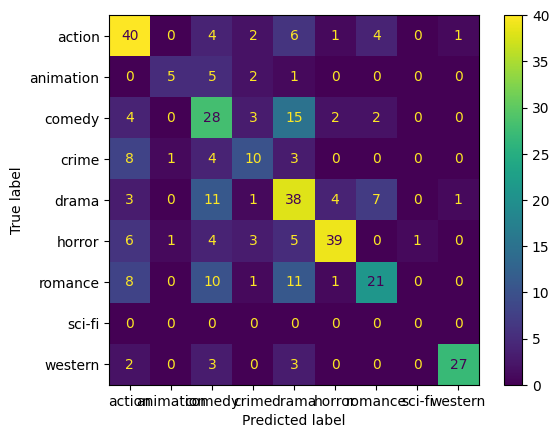

In [59]:
X_new = tfidf_vectorizer.transform(top_secret.iloc[:, 3]).toarray()  # Transform it into the TF-IDF format

# Step 3: Predict the genre using the trained MLP model
y_new_pred = clf.predict(X_new)

accuracy = accuracy_score(top_secret.iloc[:, 2], y_new_pred)

print(f"Accuracy: {accuracy*100:.2f}")
# Step 4: Decode the predicted label to the original genre
print(classification_report(y_pred=y_new_pred, y_true=top_secret.iloc[:, 2], labels = labels, zero_division=1.))

confusion_matrix(top_secret.iloc[:, 2], y_new_pred)

cm = confusion_matrix(top_secret.iloc[:, 2], y_new_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Resultados

- 54% com 

